In [1]:
import pandas as pd

df_train = pd.read_csv('train_preprocess_v3.csv')
df_test = pd.read_csv('test_preprocess_v3.csv')

print(df_train.head())
print(df_test.head())

                 id                                       comment_text  toxic  \
0  0000997932d777bf  explanation why the edits made under my userna...      0   
1  000103f0d9cfb60f  daww he matches this background colour im seem...      0   
2  000113f07ec002fd  hey man im really not trying to edit war its j...      0   
3  0001b41b1c6bb37e  more i cant make any real suggestions on impro...      0   
4  0001d958c54c6e35  you sir are my hero any chance you remember wh...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  
                 id                                       comment_text
0  00001cee341fdb12  yo bitch ja rule is more succesful then youll ...
1  0000247867823ef7    

In [2]:
# Checking for null values
print(df_train.isnull().sum())
print(df_test.isnull().sum())


id                 0
comment_text     102
toxic              0
severe_toxic       0
obscene            0
threat             0
insult             0
identity_hate      0
dtype: int64
id                0
comment_text    906
dtype: int64


In [3]:
df_train = df_train.dropna(subset=['comment_text'])
df_test = df_test.dropna(subset=['comment_text'])

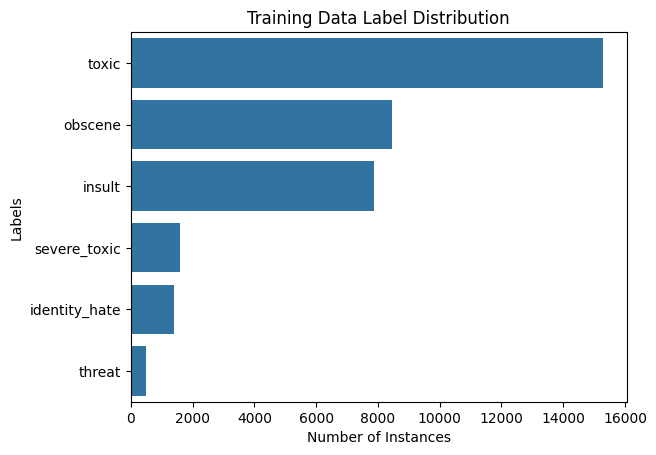

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_labels = df_train[labels].sum().sort_values(ascending=False)
sns.barplot(x = train_labels.values, y = train_labels.index)
plt.title('Training Data Label Distribution')
plt.xlabel('Number of Instances')
plt.ylabel('Labels')
plt.show()

In [5]:
# For train data
# Get a count of different data types within 'comment_text'
print("\nData type counts in 'comment_text':")
print(df_train['comment_text'].apply(type).value_counts())

# Display the number of non-string entries
non_string_count = df_train[~df_train['comment_text'].apply(lambda x: isinstance(x, str))].shape[0]
print(f"\nNumber of non-string 'comment_text' entries: {non_string_count}")

# Remove rows where 'comment_text' is not a string
train_df_cleaned = df_train[df_train['comment_text'].apply(lambda x: isinstance(x, str))].reset_index(drop=True)

# Confirm removal
non_string_count_after = train_df_cleaned[~train_df_cleaned['comment_text'].apply(lambda x: isinstance(x, str))].shape[0]
print(f"Number of non-string 'comment_text' entries after cleaning: {non_string_count_after}")


# For test data
# Get a count of different data types within 'comment_text'
print("\nData type counts in 'comment_text':")
print(df_test['comment_text'].apply(type).value_counts())

# Display the number of non-string entries
non_string_count = df_test[~df_test['comment_text'].apply(lambda x: isinstance(x, str))].shape[0]
print(f"\nNumber of non-string 'comment_text' entries: {non_string_count}")

# Remove rows where 'comment_text' is not a string
df_test_cleaned = df_test[df_test['comment_text'].apply(lambda x: isinstance(x, str))].reset_index(drop=True)

# Confirm removal
non_string_count_after = df_test_cleaned[~df_test_cleaned['comment_text'].apply(lambda x: isinstance(x, str))].shape[0]
print(f"Number of non-string 'comment_text' entries after cleaning: {non_string_count_after}")


Data type counts in 'comment_text':
comment_text
<class 'str'>    159469
Name: count, dtype: int64

Number of non-string 'comment_text' entries: 0
Number of non-string 'comment_text' entries after cleaning: 0

Data type counts in 'comment_text':
comment_text
<class 'str'>    152258
Name: count, dtype: int64

Number of non-string 'comment_text' entries: 0
Number of non-string 'comment_text' entries after cleaning: 0


In [6]:
# Splitting Data to train and validation
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

X = train_df_cleaned['comment_text'].values
y = train_df_cleaned[labels].values

mss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=41)

for train_index, val_index in mss.split(X,y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
print(f'Training samples: {len(X_train)}')
print(f'Validation samples: {len(X_val)}')


Training samples: 127575
Validation samples: 31894


In [7]:
from transformers import BertTokenizer
import re
import torch
from tqdm import tqdm

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Define maximum sequence length
MAX_LENGTH = 128

# def preprocess_text(text):
#     # Remove HTML tags
#     text = re.sub(r'<.*?>', '', text)
#     # Remove URLs
#     text = re.sub(r'http\S+', '', text)
#     # Remove special characters (optional)
#     text = re.sub(r'[^A-Za-z0-9\s]+', '', text)
#     return text

# Apply preprocessing
X_train = [text for text in X_train]
X_val = [text for text in X_val]
test_comments = [text for text in df_test_cleaned['comment_text'].values]
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 128
BATCH_SIZE = 1000  # Adjust based on your system's memory

def batch_tokenize(texts, tokenizer, max_length, batch_size):
    encodings = {
        'input_ids': [],
        'attention_mask': []
    }
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Tokenizing"):
        batch_texts = texts[i:i+batch_size]
        batch_encodings = tokenizer(
            batch_texts,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='pt'
        )
        encodings['input_ids'].append(batch_encodings['input_ids'])
        encodings['attention_mask'].append(batch_encodings['attention_mask'])
    
    # Concatenate all batches
    encodings['input_ids'] = torch.cat(encodings['input_ids'])
    encodings['attention_mask'] = torch.cat(encodings['attention_mask'])
    
    return encodings

# Tokenize training and validation data
train_encodings = batch_tokenize(X_train, tokenizer, MAX_LENGTH, BATCH_SIZE)
val_encodings = batch_tokenize(X_val, tokenizer, MAX_LENGTH, BATCH_SIZE)
test_encodings = batch_tokenize(test_comments, tokenizer, MAX_LENGTH, BATCH_SIZE)

Tokenizing: 100%|██████████| 153/153 [01:41<00:00,  1.50it/s]


In [8]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Prints your GPU name


True
NVIDIA GeForce RTX 3060 Ti


In [ ]:
# Creating Pytorch Datasets
import torch
import torch.utils
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, average_precision_score
from tqdm.auto import tqdm
from transformers import EarlyStoppingCallback
import numpy as np

class ToxicDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels  # None for test data

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])
    
train_dataset = ToxicDataset(train_encodings, y_train)
val_dataset = ToxicDataset(val_encodings, y_val)
test_dataset = ToxicDataset(test_encodings)  # No labels

from sklearn.utils.class_weight import compute_class_weight

class_weights = {}

for i,label in enumerate(labels):
    cw = compute_class_weight(
        class_weight="balanced",
        classes= np.array([0,1]),
        y=y_train[:,i]
    )
    class_weights[label] = np.log1p(cw[1])

class_weights_list = [class_weights[label] for label in labels]
print("Class Weights:", class_weights_list)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = len(labels), problem_type="multi_label_classification")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
# 7. Define Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions
    probs = torch.sigmoid(torch.tensor(preds)).numpy()
    binary_preds = (probs >= 0.5).astype(int)
    
    f1 = f1_score(labels, binary_preds, average='macro', zero_division=0)
    precision = precision_score(labels, binary_preds, average='macro', zero_division=0)
    recall = recall_score(labels, binary_preds, average='macro', zero_division=0)
    auc = roc_auc_score(labels, probs, average='macro')
    avg_precision = average_precision_score(labels, probs, average='macro')
    
    return {
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'auc': auc,
        'average_precision': avg_precision
    }

# 8. Set Up Training Arguments
training_args = TrainingArguments(
    output_dir='./results',                   # Output directory
    num_train_epochs=7,                       # Number of training epochs
    per_device_train_batch_size=32,           # Batch size per device during training
    per_device_eval_batch_size=32,            # Batch size for evaluation
    learning_rate=2e-5,  # Lower learning rate for fine-tuning
    weight_decay=0.01,                        # Strength of weight decay
    logging_dir='./logs',                     # Directory for storing logs
    logging_steps=10,                         # Log every 10 steps
    evaluation_strategy="epoch",              # Evaluate at the end of each epoch
    save_strategy="epoch",                    # Save checkpoint at each epoch
    load_best_model_at_end=True,              # Load the best model when finished training
    metric_for_best_model="f1",               # Best model is determined by the F1 score
    greater_is_better=True,                   # Whether a higher metric score is better
    save_total_limit=2,                       # Limit the total amount of checkpoints
    seed=42,                                   # Random seed for reproducibility
    fp16=True,                                 # Enable mixed precision training (requires compatible hardware)
    report_to="tensorboard",
    max_grad_norm= 1.0
    
)

import torch
import torch.nn as nn

class WeightedBCELoss(nn.Module):
    def __init__(self, class_weights):
        super(WeightedBCELoss, self).__init__()
        # Convert class_weights to a tensor; don't move to device here
        self.class_weights = torch.tensor(class_weights).float()

    def forward(self, logits, targets):
        # Ensure class_weights are on the same device as logits
        self.class_weights = self.class_weights.to(logits.device)
        # Compute Binary Cross-Entropy with Logits Loss without reduction
        bce_loss = nn.BCEWithLogitsLoss(reduction='none')(logits, targets)
        # Apply class weights
        weighted_loss = bce_loss * self.class_weights
        # Return the mean loss
        return weighted_loss.mean()


class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        if class_weights is None:
            raise ValueError("class_weights must be provided")
        self.weighted_loss = WeightedBCELoss(class_weights).to(self.model.device)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Move inputs to the same device as the model
        inputs = {key: val.to(model.device) for key, val in inputs.items() if isinstance(val, torch.Tensor)}
        
        labels = inputs.pop("labels")  # Extract labels
        outputs = model(**inputs)      # Forward pass
        logits = outputs.logits        # Get logits from model outputs
        
        # Compute weighted loss
        loss = self.weighted_loss(logits, labels)
        # Debugging: Print device info
        # print(f"Logits device: {logits.device}")
        # print(f"Labels device: {labels.device}")
        # print(f"Class Weights device: {self.weighted_loss.class_weights.device}")
        return (loss, outputs) if return_outputs else loss


import torch

# Check if CUDA is available
print(f"CUDA Available: {torch.cuda.is_available()}")

# Check model's device
print(f"Model is on device: {next(model.parameters()).device}")

# Example tensor
example_tensor = torch.tensor([1, 2, 3])
print(f"Example tensor is on device: {example_tensor.device}")

# Define device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")




Class Weights: [1.8267286522083421, 3.9316335311711703, 2.3453971167444507, 5.123862690304606, 2.408905953466444, 4.056131052226914]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CUDA Available: True
Model is on device: cuda:0
Example tensor is on device: cpu
Using device: cuda


c:\Users\hewzh\Desktop\Code\Data Cleaning\venv\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
from transformers import Trainer
#8. Trainer arguments
trainer = WeightedTrainer(
    model=model,                             # The instantiated Transformers model to be trained
    args=training_args,                      # Training arguments, defined above
    train_dataset=train_dataset,             # Training dataset
    eval_dataset=val_dataset,                # Evaluation dataset
    compute_metrics=compute_metrics,         # Function to compute metrics
    class_weights=class_weights_list
)

# 10. Start Training
trainer.train()

  0%|          | 0/27909 [00:00<?, ?it/s]

C:\Users\hewzh\AppData\Local\Temp\ipykernel_5460\560306528.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 2.2626, 'grad_norm': 10.384536743164062, 'learning_rate': 9.996775233795551e-06, 'epoch': 0.0}
{'loss': 1.8668, 'grad_norm': 10.22737979888916, 'learning_rate': 9.99319216023505e-06, 'epoch': 0.01}
{'loss': 1.4824, 'grad_norm': 7.818345546722412, 'learning_rate': 9.98960908667455e-06, 'epoch': 0.01}
{'loss': 1.1957, 'grad_norm': 6.531576633453369, 'learning_rate': 9.98602601311405e-06, 'epoch': 0.01}
{'loss': 0.9543, 'grad_norm': 4.751241683959961, 'learning_rate': 9.982442939553549e-06, 'epoch': 0.01}
{'loss': 0.7525, 'grad_norm': 3.154741048812866, 'learning_rate': 9.97885986599305e-06, 'epoch': 0.02}
{'loss': 0.6331, 'grad_norm': 2.6958231925964355, 'learning_rate': 9.97527679243255e-06, 'epoch': 0.02}
{'loss': 0.5732, 'grad_norm': 2.519179105758667, 'learning_rate': 9.97169371887205e-06, 'epoch': 0.02}
{'loss': 0.4526, 'grad_norm': 1.5121499300003052, 'learning_rate': 9.968110645311549e-06, 'epoch': 0.02}
{'loss': 0.461, 'grad_norm': 1.6681212186813354, 'learning_rate': 9.

KeyboardInterrupt: 

In [13]:
# 11. Evaluate Model
results = trainer.evaluate()
print("Evaluation Results:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")

C:\Users\hewzh\AppData\Local\Temp\ipykernel_5460\1797872413.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/997 [00:00<?, ?it/s]

Evaluation Results:
eval_loss: 0.1434
eval_f1: 0.3841
eval_precision: 0.3605
eval_recall: 0.4122
eval_auc: 0.9664
eval_average_precision: 0.5360
eval_runtime: 42.4806
eval_samples_per_second: 750.7890
eval_steps_per_second: 23.4700
epoch: 0.1756


In [24]:
trainer.save_model("./final_model3")  # Saves the model and tokenizer
tokenizer.save_pretrained("./final_model3")  # Optional: Save tokenizer separately

('./final_model2\\tokenizer_config.json',
 './final_model2\\special_tokens_map.json',
 './final_model2\\vocab.txt',
 './final_model2\\added_tokens.json')

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you are using Hugging Face's Trainer
outputs = trainer.predict(val_dataset)  # Evaluate on the validation dataset

# Extract predictions and true labels
predictions = outputs.predictions  # Raw logits
true_labels = outputs.label_ids     # True labels from the dataset

# Convert logits to probabilities
probabilities = torch.sigmoid(torch.tensor(predictions)).numpy()

# Convert probabilities to binary predictions (threshold = 0.5 by default)
binary_predictions = (probabilities >= 0.5).astype(int)


CUDA Available: True
Model is on device: cuda:0
Example tensor is on device: cpu


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrices for each label
confusion_matrices = {}
for i, label in enumerate(labels):
    cm = confusion_matrix(true_labels[:, i], binary_predictions[:, i])
    confusion_matrices[label] = cm

# Display confusion matrices
for label, cm in confusion_matrices.items():
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.title(f"Confusion Matrix for {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

# Compute metrics for each label
for i, label in enumerate(labels):
    precision = precision_score(true_labels[:, i], binary_predictions[:, i], zero_division=0)
    recall = recall_score(true_labels[:, i], binary_predictions[:, i], zero_division=0)
    f1 = f1_score(true_labels[:, i], binary_predictions[:, i], zero_division=0)
    print(f"Metrics for {label}: Precision={precision:.2f}, Recall={recall:.2f}, F1={f1:.2f}")



In [16]:



# # Load tokenizer and model
# tokenizer = BertTokenizer.from_pretrained('./final_model2')
# model = BertForSequenceClassification.from_pretrained('./final_model2')
# model.eval()  # Set to evaluation mode




Using device: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# test_comments = df_test_cleaned['comment_text'].tolist()
# # Define prediction function
# def predict(text, tokenizer, model, device, max_length=128):
#     inputs = tokenizer(
#         text,
#         return_tensors='pt',
#         truncation=True,
#         padding='max_length',
#         max_length=max_length
#     )
#     # Move inputs to device
#     inputs = {key: value.to(device) for key, value in inputs.items()}
    
#     with torch.no_grad():
#         outputs = model(**inputs)
#         logits = outputs.logits
#         probabilities = torch.sigmoid(logits).cpu().numpy()[0]  # Move to CPU for numpy operations
#     binary_preds = (probabilities >= 0.5).astype(int)
#     return binary_preds, probabilities

# # Perform predictions
# predictions = []
# probabilities = []

# for comment in test_comments:
#     binary_pred, prob = predict(comment, tokenizer, model, device)
#     predictions.append(binary_pred)
#     probabilities.append(prob)

# # Convert predictions to DataFrame
# labels = ['toxic', 'severe_toxic', 'obscene', 'insult', 'identity_hate', 'threat']
# preds_df = pd.DataFrame(predictions, columns=labels)
# probs_df = pd.DataFrame(probabilities, columns=[f"{label}_prob" for label in labels])

# # Combine with test IDs
# submission_df = pd.concat([df_test_cleaned['id'], preds_df, probs_df], axis=1)

# # Save to CSV
# submission_df.to_csv('test_predictions.csv', index=False)
# print("Predictions saved to 'test_predictions.csv'")

Predictions saved to 'test_predictions.csv'
